### GCP bigquery example


In [1]:
# imports
import numpy as np
import pandas as pd
pd.set_option('display.width', 1000)

import os
import wget
import zipfile

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder

# tools for getting data
from google.cloud import bigquery

from ipywidgets import interact, interact_manual
import ipywidgets as widgets
import wordcloud
import matplotlib.pyplot as plt

import calmap


In [2]:
# do some setup to make sure visualization controls work
# from cli: jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [3]:
# get hackernews data using bigquery
# https://www.kaggle.com/sohier/beyond-queries-exploring-the-bigquery-api
# if you need to setup google api credentials, see this ref: https://cloud.google.com/docs/authentication/getting-started
# you may also need to use google cloud console to enable 'bigquery' for your query user/api key
# https://cloud.google.com/bigquery/docs/access-control
# hackernews feed updated daily:  https://medium.com/@hoffa/hacker-news-on-bigquery-now-with-daily-updates-so-what-are-the-top-domains-963d3c68b2e2
client = bigquery.Client()
hn_dataset_ref = client.dataset('hacker_news', project='bigquery-public-data')


In [4]:
# check that connection works
type(hn_dataset_ref)

google.cloud.bigquery.dataset.DatasetReference

In [5]:
hn_dset = client.get_dataset(hn_dataset_ref)
[x.table_id for x in client.list_tables(hn_dset)]

['comments', 'full', 'full_201510', 'stories']

In [6]:
hn_full = client.get_table(hn_dset.table('full'))
type(hn_full)

google.cloud.bigquery.table.Table

In [7]:
[command for command in dir(hn_full) if not command.startswith('_')]

['clustering_fields',
 'created',
 'dataset_id',
 'description',
 'encryption_configuration',
 'etag',
 'expires',
 'external_data_configuration',
 'friendly_name',
 'from_api_repr',
 'from_string',
 'full_table_id',
 'labels',
 'location',
 'modified',
 'num_bytes',
 'num_rows',
 'partition_expiration',
 'partitioning_type',
 'path',
 'project',
 'reference',
 'schema',
 'self_link',
 'streaming_buffer',
 'table_id',
 'table_type',
 'time_partitioning',
 'to_api_repr',
 'to_bqstorage',
 'view_query',
 'view_use_legacy_sql']

In [8]:
hn_full.schema

[SchemaField('by', 'STRING', 'NULLABLE', "The username of the item's author.", ()),
 SchemaField('score', 'INTEGER', 'NULLABLE', 'Story score', ()),
 SchemaField('time', 'INTEGER', 'NULLABLE', 'Unix time', ()),
 SchemaField('timestamp', 'TIMESTAMP', 'NULLABLE', 'Timestamp for the unix time', ()),
 SchemaField('title', 'STRING', 'NULLABLE', 'Story title', ()),
 SchemaField('type', 'STRING', 'NULLABLE', 'Type of details (comment, comment_ranking, poll, story, job, pollopt)', ()),
 SchemaField('url', 'STRING', 'NULLABLE', 'Story url', ()),
 SchemaField('text', 'STRING', 'NULLABLE', 'Story or comment text', ()),
 SchemaField('parent', 'INTEGER', 'NULLABLE', 'Parent comment ID', ()),
 SchemaField('deleted', 'BOOLEAN', 'NULLABLE', 'Is deleted?', ()),
 SchemaField('dead', 'BOOLEAN', 'NULLABLE', 'Is dead?', ()),
 SchemaField('descendants', 'INTEGER', 'NULLABLE', 'Number of story or poll descendants', ()),
 SchemaField('id', 'INTEGER', 'NULLABLE', "The item's unique id.", ()),
 SchemaField('ran

In [9]:
# if we've already downloaded the info, load saved csv - else run new GCP query
saved_datafile = "hackernews_ML_articles.csv"

# check if source data exists - returns True/False
data_exists = os.path.exists(saved_datafile)  

if data_exists:
    headlines = pd.read_csv(saved_datafile)
    print("data file loaded")
else:
    # get source data from bigquery  -- https://www.kaggle.com/mrisdal/mentions-of-kaggle-on-hacker-news
    # use GCP to test query on console first (with limit): https://console.cloud.google.com/bigquery

    # Using WHERE reduces the amount of data scanned / quota used
    query = """
    SELECT id, author, title, time_ts, score, url
    FROM `bigquery-public-data.hacker_news.stories`
    WHERE url IS NOT NULL
    AND REGEXP_CONTAINS(title, r"(m|M)achine (l|L)earning")
    ORDER BY time_ts;
    """

    query_job = client.query(query)

    iterator = query_job.result(timeout=60)
    rows = list(iterator)

    # Transform the rows into a nice pandas dataframe
    headlines = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
    
    # save to csv to avoid query costs
    headlines.to_csv("hackernews_ML_articles.csv" ,  sep=',', header=True)

# Look at the first 10 headlines
headlines.head(10)

data file loaded


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,author,title,time_ts,score,url
0,0,0,0,9520,bootload,Delicious tags & machine learning,2007-04-06 03:58:32+00:00,1,http://www.smokingrobot.com/news/archives/perm...
1,1,1,1,46778,nickb,Machine Learning and The Privacy Problem,2007-08-26 18:34:47+00:00,2,http://hunch.net/?p=288
2,2,2,2,58532,aquarin,Map-Reduce for Machine Learning on Multicore (...,2007-09-23 13:08:53+00:00,10,http://www.cs.stanford.edu/people/ang//papers/...
3,3,3,3,58600,ivankirigin,Machine Learning Animations from CMU's Auton L...,2007-09-23 20:02:14+00:00,9,http://www.autonlab.org/autonweb/library/anima...
4,4,4,4,64637,tocomment,Machine Learning and Dragons - A Game,2007-10-08 05:18:34+00:00,22,http://www.blendedtechnologies.com/machine-lea...
5,5,5,5,79359,jkush,"Can anyone recommend good books, articles or e...",2007-11-13 17:45:17+00:00,27,NaN
6,6,6,6,90234,hhm,"Machine Learning (classic book, by Tom Mitchell)",2007-12-17 04:25:16+00:00,1,http://books.google.com/books?id=I5GcpyPx3RwC&...
7,7,7,7,132188,kurtosis,Ask YC: Real World Applications of Machine Lea...,2008-03-08 22:35:20+00:00,17,NaN
8,8,8,8,133682,mardeo,CastTV - Hiring Hackers: Fascinated by machine...,2008-03-11 01:14:05+00:00,2,http://casttv.com/jobs/
9,9,9,9,198601,bluishgreen,Ask YC: Machine learning course recommendation.,2008-05-24 03:47:27+00:00,43,NaN


In [10]:
headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1855 entries, 0 to 1854
Data columns (total 9 columns):
Unnamed: 0        1855 non-null int64
Unnamed: 0.1      1855 non-null int64
Unnamed: 0.1.1    1855 non-null int64
id                1855 non-null int64
author            1855 non-null object
title             1855 non-null object
time_ts           1855 non-null object
score             1855 non-null int64
url               1731 non-null object
dtypes: int64(5), object(4)
memory usage: 130.5+ KB


In [11]:
# create a wordcloud to see big themes across articles

In [12]:
# download nicer font for wordcloud
# free national park font: https://nationalparktypeface.com/Download
# download URL: https://files.cargocollective.com/c206464/NationalPark.zip
# if we haven't downloaded fonts, create a font dir; then download and unzip
font_dir = "fonts"
font_dir_exists = os.path.isdir(font_dir)
font_zipfile = os.path.exists("NationalPark.zip")

if not font_dir_exists:
    new_font_dir = os.path.join(os.getcwd(), "fonts")
    try:  
        os.mkdir(new_font_dir)
    except OSError:  
        print ("Creation of the directory %s failed" % new_font_dir)
    else:  
        print ("Successfully created the directory %s " % new_font_dir)
        font_dir = os.path.isdir(font_dir)
else:
    print("font directory already exists")


if not font_zipfile:
    source_url = 'https://files.cargocollective.com/c206464/NationalPark.zip'
    file = source_url.split('/')[-1]
    print(file)
    filename = wget.download(source_url)
    print("file downloaded")
    zf = zipfile.ZipFile(file)
    zf.extractall(path="fonts", members=None, pwd=None)
    # zipfile.ZipFile.extractall(path="fonts", mode='r', members=None, pwd=None)
    print("all font files extracted to fonts/")
else:
    print("NationalPark.zip font file already downloaded")
    source_url = 'https://files.cargocollective.com/c206464/NationalPark.zip'
    file = source_url.split('/')[-1]
    zf = zipfile.ZipFile(file)
    zf.extractall(path="fonts", members=None, pwd=None)
    # zipfile.ZipFile.extractall(path="fonts", mode='r', members=None, pwd=None)
    print("all font files extracted to fonts/")
    

font directory already exists
NationalPark.zip font file already downloaded
all font files extracted to fonts/


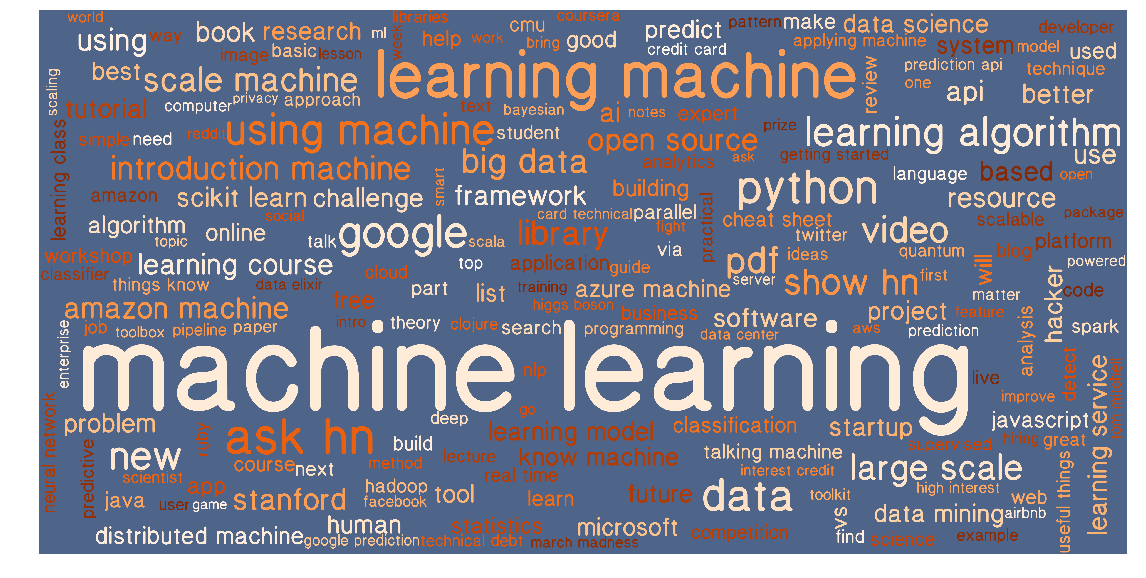

In [13]:
# create wordcloud
words = ' '.join(headlines.title).lower()
font_path = os.path.abspath("fonts/NationalPark-Regular.otf")  # replace default font

# image looks cleaner if we set fig size first, and make wordcloud width/height very large
plt.figure(figsize=(20,10))
cloud = wordcloud.WordCloud(background_color='#4e6489',
                            colormap='Oranges',
                            font_path=font_path,
                            max_font_size=600,
                            width=5000,
                            height=2500,
                            max_words=200,
                            relative_scaling=.5).generate(words)
plt.axis('off')
plt.savefig('kaggle-hackernews.png')
plt.imshow(cloud);

In [14]:
headlines.head(5)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,author,title,time_ts,score,url
0,0,0,0,9520,bootload,Delicious tags & machine learning,2007-04-06 03:58:32+00:00,1,http://www.smokingrobot.com/news/archives/perm...
1,1,1,1,46778,nickb,Machine Learning and The Privacy Problem,2007-08-26 18:34:47+00:00,2,http://hunch.net/?p=288
2,2,2,2,58532,aquarin,Map-Reduce for Machine Learning on Multicore (...,2007-09-23 13:08:53+00:00,10,http://www.cs.stanford.edu/people/ang//papers/...
3,3,3,3,58600,ivankirigin,Machine Learning Animations from CMU's Auton L...,2007-09-23 20:02:14+00:00,9,http://www.autonlab.org/autonweb/library/anima...
4,4,4,4,64637,tocomment,Machine Learning and Dragons - A Game,2007-10-08 05:18:34+00:00,22,http://www.blendedtechnologies.com/machine-lea...


In [15]:
# Generate a slider
@interact
def show_articles_more_than(column='score', x=int(headlines['score'].max()/3)):
    return headlines.loc[headlines[column] > x].sort_values(by="score", ascending=False)


interactive(children=(Text(value='score', description='column'), IntSlider(value=183, description='x', max=549…

In [16]:
import qgrid

In [17]:
# qgrid enables interactive filtering of the entire dataframe; more convenient than manual slicing
qgrid.show_grid(headlines)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [18]:
# breakout time data into useful columns
import datetime as dt

headlines['time_ts'] = pd.to_datetime(headlines['time_ts'])   # cast to datetime type

headlines['date'] = pd.DatetimeIndex(headlines['time_ts']).date
headlines['date'] = pd.to_datetime(headlines['date'])
headlines['year'] = pd.DatetimeIndex(headlines['time_ts']).year
headlines['year'] = pd.to_datetime(headlines['year'])
headlines['month'] = pd.DatetimeIndex(headlines['time_ts']).month
headlines['month'] = pd.to_datetime(headlines['month'])
headlines['day'] = pd.DatetimeIndex(headlines['time_ts']).day
headlines['day'] = pd.to_datetime(headlines['day'])
headlines['day_name'] = headlines[['time_ts']].apply(lambda x: dt.datetime.strftime(x['time_ts'], '%A'), axis=1)

In [19]:
headlines.head(5)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,author,title,time_ts,score,url,date,year,month,day,day_name
0,0,0,0,9520,bootload,Delicious tags & machine learning,2007-04-06 03:58:32+00:00,1,http://www.smokingrobot.com/news/archives/perm...,2007-04-06,1970-01-01 00:00:00.000002007,1970-01-01 00:00:00.000000004,1970-01-01 00:00:00.000000006,Friday
1,1,1,1,46778,nickb,Machine Learning and The Privacy Problem,2007-08-26 18:34:47+00:00,2,http://hunch.net/?p=288,2007-08-26,1970-01-01 00:00:00.000002007,1970-01-01 00:00:00.000000008,1970-01-01 00:00:00.000000026,Sunday
2,2,2,2,58532,aquarin,Map-Reduce for Machine Learning on Multicore (...,2007-09-23 13:08:53+00:00,10,http://www.cs.stanford.edu/people/ang//papers/...,2007-09-23,1970-01-01 00:00:00.000002007,1970-01-01 00:00:00.000000009,1970-01-01 00:00:00.000000023,Sunday
3,3,3,3,58600,ivankirigin,Machine Learning Animations from CMU's Auton L...,2007-09-23 20:02:14+00:00,9,http://www.autonlab.org/autonweb/library/anima...,2007-09-23,1970-01-01 00:00:00.000002007,1970-01-01 00:00:00.000000009,1970-01-01 00:00:00.000000023,Sunday
4,4,4,4,64637,tocomment,Machine Learning and Dragons - A Game,2007-10-08 05:18:34+00:00,22,http://www.blendedtechnologies.com/machine-lea...,2007-10-08,1970-01-01 00:00:00.000002007,1970-01-01 00:00:00.000000010,1970-01-01 00:00:00.000000008,Monday


In [20]:
events = pd.Series(headlines['date'])
events[:10]

0   2007-04-06
1   2007-08-26
2   2007-09-23
3   2007-09-23
4   2007-10-08
5   2007-11-13
6   2007-12-17
7   2008-03-08
8   2008-03-11
9   2008-05-24
Name: date, dtype: datetime64[ns]

In [21]:
headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1855 entries, 0 to 1854
Data columns (total 14 columns):
Unnamed: 0        1855 non-null int64
Unnamed: 0.1      1855 non-null int64
Unnamed: 0.1.1    1855 non-null int64
id                1855 non-null int64
author            1855 non-null object
title             1855 non-null object
time_ts           1855 non-null datetime64[ns, UTC]
score             1855 non-null int64
url               1731 non-null object
date              1855 non-null datetime64[ns]
year              1855 non-null datetime64[ns]
month             1855 non-null datetime64[ns]
day               1855 non-null datetime64[ns]
day_name          1855 non-null object
dtypes: datetime64[ns, UTC](1), datetime64[ns](4), int64(5), object(4)
memory usage: 203.0+ KB


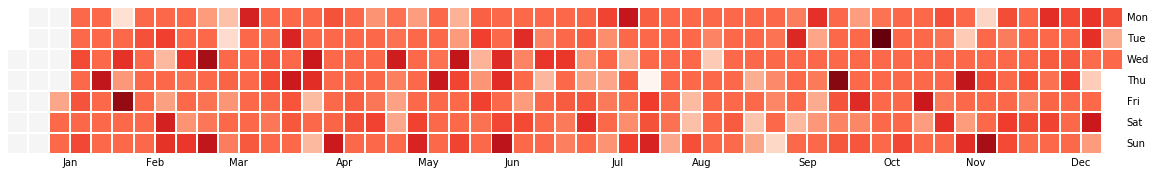

In [22]:
# create a calendar map - here is a quick example
np.random.seed(sum(map(ord, 'calmap')))
import pandas as pd
import calmap

plt.figure(figsize=(20,10))
all_days = pd.date_range('1/15/2014', periods=700, freq='D')
days = np.random.choice(all_days, 500)
events = pd.Series(np.random.randn(len(days)), index=days)
calmap.yearplot(events, year=2014)

In [23]:
events[:10]

2015-12-11   -0.998662
2014-06-17   -0.136021
2014-11-04   -0.240216
2014-02-07    0.217959
2014-05-05   -0.188949
2014-05-21   -0.171695
2014-12-11   -0.143083
2014-04-11   -1.030827
2014-03-27    0.605146
2015-06-13    0.162624
dtype: float64

In [24]:
# create a calendar map for our headlines data
events2 = headlines[['date', 'id']].groupby(['date']).agg(['count'])
events2[:10]

,id
,count
date,
2007-04-06,1
2007-08-26,1
2007-09-23,2
2007-10-08,1
2007-11-13,1
2007-12-17,1
2008-03-08,1
2008-03-11,1


In [25]:
date1 = '2008-05-03'
date2 = '2019-05-10'
mydates = pd.date_range(date1, date2).tolist()

In [26]:
len(mydates)

4025

In [27]:
# create array of all dates in our min-max range, with zero counts
date1 = headlines['date'].min()
date2 = headlines['date'].max()
print(date1, date2)
mydates = pd.date_range(date1, date2).tolist()

len(mydates)

mydates2 = pd.date_range(date1, date2)
mydates2 = pd.DataFrame(mydates2)
mydates2.columns = ['date']
mydates2.head(5)

2007-04-06 00:00:00 2015-10-12 00:00:00


,date
0,2007-04-06
1,2007-04-07
2,2007-04-08
3,2007-04-09
4,2007-04-10


In [28]:
events2[:5]

,id
,count
date,
2007-04-06,1
2007-08-26,1
2007-09-23,2
2007-10-08,1
2007-11-13,1


In [29]:
result = pd.merge(mydates2, events2, on='date', how='outer')
result = result.sort_values('date')
result = result.fillna(value=0)
result.columns = ['date', 'count']
result['count'] = result['count'].astype(int)
result = result.set_index('date', 'count')
result.head(10)

d:\dropbox\0.surfaceowl\dev\probable-eureka_scikit-learn\venv\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,count
date,
2007-04-06,1
2007-04-07,0
2007-04-08,0
2007-04-09,0
2007-04-10,0
2007-04-11,0
2007-04-12,0
2007-04-13,0
2007-04-14,0


In [30]:
result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3112 entries, 2007-04-06 to 2015-10-12
Data columns (total 1 columns):
count    3112 non-null int32
dtypes: int32(1)
memory usage: 36.5 KB
